### Setup - imports, constants, download of data from GitHub

In [79]:
import os
import glob
import tensorflow as tf
import tensorflow.keras.models as tfm
import tensorflow.keras.layers as tfl
import tensorflow.keras.callbacks as tfc
import tensorflow.keras.utils as tfu
import sklearn.model_selection as skms
import sklearn.metrics as skm
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import time
import functools
import IPython.display as ipd
import pandas as pd

os.system("pip install keras-flops > /dev/null")
import keras_flops as kf

SEED = 42
IMAGE_HEIGHT = 20
IMAGE_WIDTH = 20
SAMPLES_PER_MEASUREMENT = 119
LINES_PER_MEASUREMENT = SAMPLES_PER_MEASUREMENT + 1
IMAGE_WIDTH_HEIGHT_INDEX = IMAGE_WIDTH - 1
SAMPLES_PER_MEASUREMENT_CROPPED = 110
FRONT_CROP = 2
BACK_CROP = 7
NUMBER_OF_LABELS = 5
LABELS = ["Alohomora", "Arresto Momentum", "Avada Kedavra", "Locomotor", "Revelio"]

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

LARGE_DATA_SET = True  # set to True to train on larger data set
POOR_MODELS = False     # set to True to train also model, for which training fails
FULL_INPUT = True      # set to True to train on full 119 samples of a spell, otherwise start and end are scopped to 110 samples

# create input/output directories and download data
os.makedirs("figures", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("data", exist_ok=True)
os.makedirs("data_large", exist_ok=True)

if not os.path.isfile("data/spells.zip") and not LARGE_DATA_SET:
    os.system("wget -P data/ https://github.com/xmihol00/robust_magic_wand/raw/main/data/spells.zip")
    os.system("unzip data/spells.zip")

if not os.path.isfile("data_large/spells.zip") and LARGE_DATA_SET:
    os.system("wget -P data_large/ https://github.com/xmihol00/robust_magic_wand/raw/main/data_large/spells.zip")
    os.system("unzip data_large/spells.zip")

### Functions for data processing, creation of data sets and model analysis

In [80]:
def get_stroke_samples(data):
    angle_samples = np.zeros((SAMPLES_PER_MEASUREMENT, 3))
    stroke_samples = np.zeros((SAMPLES_PER_MEASUREMENT, 2))
    rows_of_samples = [list(map(lambda x: float(x), line.split(','))) for line in data.split('\n') if line]

    for i in range(0, len(rows_of_samples), SAMPLES_PER_MEASUREMENT): 
        measurment = np.array(rows_of_samples[i: i+SAMPLES_PER_MEASUREMENT])
        acceleration_average = np.average(measurment[:, 0:3], axis=0)

        # calcualte angle
        previous_angle = np.zeros(3)
        for j, gyro_sample in enumerate(measurment[:, 3:6]):
            angle_samples[j] = previous_angle + gyro_sample / SAMPLES_PER_MEASUREMENT
            previous_angle = angle_samples[j]     
        angle_avg = np.average(angle_samples, axis=0) # average angle

        # calculate stroke
        acceleration_magnitude = np.sqrt(acceleration_average.dot(acceleration_average.T)) # dot product insted of squaring
        acceleration_magnitude += (acceleration_magnitude < 0.0001) * 0.0001 # prevent division by 0
        normalzied_acceleration = acceleration_average / acceleration_magnitude
        normalized_angle = angle_samples - angle_avg
        stroke_samples[:, 0] = -normalzied_acceleration[1] * normalized_angle[:, 1] - normalzied_acceleration[2] * normalized_angle[:, 2]
        stroke_samples[:, 1] =  normalzied_acceleration[1] * normalized_angle[:, 2] - normalzied_acceleration[2] * normalized_angle[:, 1]
        yield stroke_samples

def laod_dataset_as_arrays_and_images(directory, one_hot=True, seed=SEED):
    data = ""
    labels = []
    for i, file_name in enumerate(sorted(glob.glob(f"{directory}/*.csv"))): # sort the labels alphabetically
        file = open(file_name, "r")
        file.readline() # skip header
        read_lines = file.read()
        labels += [i] * (read_lines.count("\n") // LINES_PER_MEASUREMENT)
        data += read_lines
        file.close()

    arrays = np.zeros((len(labels), 2 * SAMPLES_PER_MEASUREMENT), dtype=np.float32)
    colors = np.linspace(255 - 2 * SAMPLES_PER_MEASUREMENT + 2, 255, SAMPLES_PER_MEASUREMENT) / 255
    images = np.zeros((len(labels), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)

    for i, stroke_samples in enumerate(get_stroke_samples(data)): 
        stroke_samples -= np.min(stroke_samples, axis=0) # make samples in range from 0 to x
        stroke_samples /= np.max(stroke_samples, axis=0) # normalize values from 0 to 1
        arrays[i] = stroke_samples.reshape(-1)
        
        # rasterize stroke
        pixels = np.round(stroke_samples * IMAGE_WIDTH_HEIGHT_INDEX, 0).astype(np.uint8) # normalize samples to the whole image
        image = np.zeros((IMAGE_WIDTH, IMAGE_HEIGHT))
        image[pixels[:, 1], pixels[:, 0]] = colors
        images[i] = image.reshape(IMAGE_WIDTH, IMAGE_HEIGHT, 1).astype(np.float32)


    both_variants = [skms.train_test_split(arrays, labels, test_size=0.2, random_state=seed),
                     skms.train_test_split(images, labels, test_size=0.2, random_state=seed)]

    for i in range(len(both_variants)):
        X_train, X_test, y_train, y_test = both_variants[i]
        y_test = np.array(y_test)
        if one_hot:
            # one-hot encoding of labels
            y_train = tfu.to_categorical(y_train, num_classes=5)
        both_variants[i] = (X_train, X_test, y_train, y_test)
       
    return both_variants

def laod_dataset_as_arrays_and_images_cropped(directory, one_hot=True, seed=SEED):
    data = ""
    labels = []
    for i, file_name in enumerate(sorted(glob.glob(f"{directory}/*.csv"))):
        file = open(file_name, "r")
        file.readline() # skip header
        read_lines = file.read()
        labels += [i] * (read_lines.count("\n") // LINES_PER_MEASUREMENT)
        data += read_lines
        file.close()

    arrays = np.zeros((len(labels), 2 * SAMPLES_PER_MEASUREMENT_CROPPED), dtype=np.float32)
    colors = np.linspace(255 - 2 * SAMPLES_PER_MEASUREMENT_CROPPED + 2, 255, SAMPLES_PER_MEASUREMENT_CROPPED) / 255
    images = np.zeros((len(labels), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)

    for i, stroke_samples in enumerate(get_stroke_samples(data)): 
        stroke_samples -= np.min(stroke_samples, axis=0) # make samples in range from 0 to x
        stroke_samples /= np.max(stroke_samples, axis=0) # normalize values from 0 to 1
        stroke_samples = stroke_samples[FRONT_CROP:-BACK_CROP, :]
        arrays[i] = stroke_samples.reshape(-1)
        
        # rasterize stroke
        pixels = np.round(stroke_samples * IMAGE_WIDTH_HEIGHT_INDEX, 0).astype(np.uint8) # normalize samples to the whole image
        image = np.zeros((IMAGE_WIDTH, IMAGE_HEIGHT))
        image[pixels[:, 1], pixels[:, 0]] = colors
        images[i] = image.reshape(IMAGE_WIDTH, IMAGE_HEIGHT, 1).astype(np.float32)


    both_variants = [skms.train_test_split(arrays, labels, test_size=0.2, random_state=seed),
                     skms.train_test_split(images, labels, test_size=0.2, random_state=seed)]

    for i in range(len(both_variants)):
        X_train, X_test, y_train, y_test = both_variants[i]
        y_test = np.array(y_test)
        if one_hot:
            # one-hot encoding of labels
            y_train = tfu.to_categorical(y_train, num_classes=5)
        both_variants[i] = (X_train, X_test, y_train, y_test)
       
    return both_variants

def representative_dataset(data_set):
    for sample in data_set:
        yield [np.expand_dims(sample, 0)]

def collect_model_summary(summary_line, model_dict):
    match = re.match(r"(.*?): ([\d,]+)", summary_line)
    if match:
        match = match.groups()
        model_dict[match[0].replace("params", "parameters")] = int(match[1].replace(',', ''))

### Model definitions

In [81]:
hidden_activation = tf.keras.layers.LeakyReLU(0.1)
droput_1 = 0.4
droput_2 = 0.3
droput_3 = 0.25

models = [
    tfm.Sequential([
        tfl.Dense(units=5, activation="softmax")
    ]),

    tfm.Sequential([
        tfl.Dense(units=50, activation=hidden_activation),
        tfl.Dense(units=25, activation=hidden_activation),
        tfl.Dense(units=5, activation="softmax")
    ]),

    tfm.Sequential([
        tfl.Dense(units=100, activation=hidden_activation),
        tfl.Dense(units=5, activation="softmax")
    ]),

    tfm.Sequential([
        tfl.Dense(units=100, activation=hidden_activation),
        tfl.Dense(units=50, activation=hidden_activation),
        tfl.Dense(units=5, activation="softmax")
    ]),

    tfm.Sequential([
        tfl.Conv2D(filters=8, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=16, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=32, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.MaxPool2D(),
        tfl.Flatten(),
        tfl.Dense(units=32, activation=hidden_activation),
        tfl.Dense(units=5, activation="softmax"),
    ]),

    tfm.Sequential([
        tfl.Conv2D(filters=16, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=32, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=64, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.MaxPool2D(),
        tfl.Flatten(),
        tfl.Dense(units=64, activation=hidden_activation),
        tfl.Dense(units=5, activation="softmax"),
    ]),

    tfm.Sequential([
        tfl.Conv2D(filters=16, kernel_size=(5, 5), activation=hidden_activation, padding="valid"),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=32, kernel_size=(3, 3), activation=hidden_activation, padding="valid"),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=64, kernel_size=(3, 3), activation=hidden_activation, padding="valid"),
        tfl.Conv2D(filters=5, kernel_size=(1, 1), activation="softmax", padding="same"),
        tfl.Reshape([5])
    ]),

    tfm.Sequential([
        tfl.Conv2D(filters=32, kernel_size=(5, 5), activation=hidden_activation, padding="valid"),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=64, kernel_size=(3, 3), activation=hidden_activation, padding="valid"),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=128, kernel_size=(3, 3), activation=hidden_activation, padding="valid"),
        tfl.Conv2D(filters=5, kernel_size=(1, 1), activation="softmax", padding="same"),
        tfl.Reshape([5])
    ]),

    tfm.Sequential([
        tfl.Dense(units=50, activation=hidden_activation),
        tfl.Dropout(droput_2),
        tfl.Dense(units=25, activation=hidden_activation),
        tfl.Dropout(droput_3),
        tfl.Dense(units=5, activation="softmax")
    ]),

    tfm.Sequential([
        tfl.Dense(units=100, activation=hidden_activation),
        tfl.Dropout(droput_1),
        tfl.Dense(units=5, activation="softmax")
    ]),

    tfm.Sequential([
        tfl.Dense(units=100, activation=hidden_activation),
        tfl.Dropout(droput_1),
        tfl.Dense(units=50, activation=hidden_activation),
        tfl.Dropout(droput_2),
        tfl.Dense(units=5, activation="softmax")
    ]),

    tfm.Sequential([
        tfl.Conv2D(filters=8, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=16, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=32, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.MaxPool2D(),
        tfl.Flatten(),
        tfl.Dropout(droput_1),
        tfl.Dense(units=32, activation=hidden_activation),
        tfl.Dropout(droput_2),
        tfl.Dense(units=5, activation="softmax"),
    ]),

    tfm.Sequential([
        tfl.Conv2D(filters=16, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=32, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=64, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.MaxPool2D(),
        tfl.Flatten(),
        tfl.Dropout(droput_1),
        tfl.Dense(units=64, activation=hidden_activation),
        tfl.Dropout(droput_2),
        tfl.Dense(units=5, activation="softmax"),
    ]),

    tfm.Sequential([
        tfl.Conv2D(filters=16, kernel_size=(5, 5), activation=hidden_activation, padding="valid"),
        tfl.BatchNormalization(),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=32, kernel_size=(3, 3), activation=hidden_activation, padding="valid"),
        tfl.BatchNormalization(),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=64, kernel_size=(3, 3), activation=hidden_activation, padding="valid"),
        tfl.BatchNormalization(),
        tfl.Conv2D(filters=5, kernel_size=(1, 1), activation="softmax", padding="same"),
        tfl.Reshape([5])
    ]),

    tfm.Sequential([
        tfl.Conv2D(filters=32, kernel_size=(5, 5), activation=hidden_activation, padding="valid"),
        tfl.BatchNormalization(),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=64, kernel_size=(3, 3), activation=hidden_activation, padding="valid"),
        tfl.BatchNormalization(),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=128, kernel_size=(3, 3), activation=hidden_activation, padding="valid"),
        tfl.BatchNormalization(),
        tfl.Conv2D(filters=5, kernel_size=(1, 1), activation="softmax", padding="same"),
        tfl.Reshape([5])
    ]),

    tfm.Sequential([
        tfl.Conv2D(filters=8, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.BatchNormalization(),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=16, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.BatchNormalization(),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=32, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.BatchNormalization(),
        tfl.MaxPool2D(),
        tfl.Flatten(),
        tfl.Dropout(droput_1),
        tfl.Dense(units=32, activation=hidden_activation),
        tfl.Dropout(droput_2),
        tfl.Dense(units=5, activation="softmax"),
    ]),

    tfm.Sequential([
        tfl.Conv2D(filters=16, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.BatchNormalization(),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=32, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.BatchNormalization(),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=64, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.BatchNormalization(),
        tfl.MaxPool2D(),
        tfl.Flatten(),
        tfl.Dropout(droput_1),
        tfl.Dense(units=64, activation=hidden_activation),
        tfl.Dropout(droput_2),
        tfl.Dense(units=5, activation="softmax"),
    ]),
]

model_names = [
    "baseline_linear",
    "Only_DENS_S", "Only_DENS_M", "Only_DENS_L",
    "CONV_DENS_S", "CONV_DENS_L", 
    "Only_CONV_S", "Only_CONV_L",
    "Only_DENS_DO_S", "Only_DENS_DO_M", "Only_DENS_DO_L",
    "CONV_DENS_DO_S", "CONV_DENS_DO_L",
    "Only_CONV_BN_S", "Only_CONV_BN_L",
    "CONV_DENS_BN_DO_S", "CONV_DENS_BN_DO_L",
]

model_data_sets = [
    0,
    0, 0, 0,
    1, 1,
    1, 1,
    0, 0, 0,
    1, 1,
    1, 1,
    1, 1
]

selected_models = [ "Only_DENS_L", "CONV_DENS_DO_L" ]

if not POOR_MODELS:
    models = models[:-4]
    model_names = model_names[:-4]
    model_data_sets = model_data_sets[:-4]


table_header = ["Total parameters", "Trainable parameters", "Non-trainable parameters", "Size", "Optimized size", "Training time GPU", 
                "Epochs", "FLOPS", "Full model accuracy", "Optimized model accuracy", "Full model inference time", "Optimized model inference time"]

### Load data sets and get the order of labels

In [82]:
if FULL_INPUT:
    data_sets = laod_dataset_as_arrays_and_images("data_large" if LARGE_DATA_SET else "data")
else:
    data_sets = laod_dataset_as_arrays_and_images_cropped("data_large" if LARGE_DATA_SET else "data")

### Training and collection of statistics and results

[]

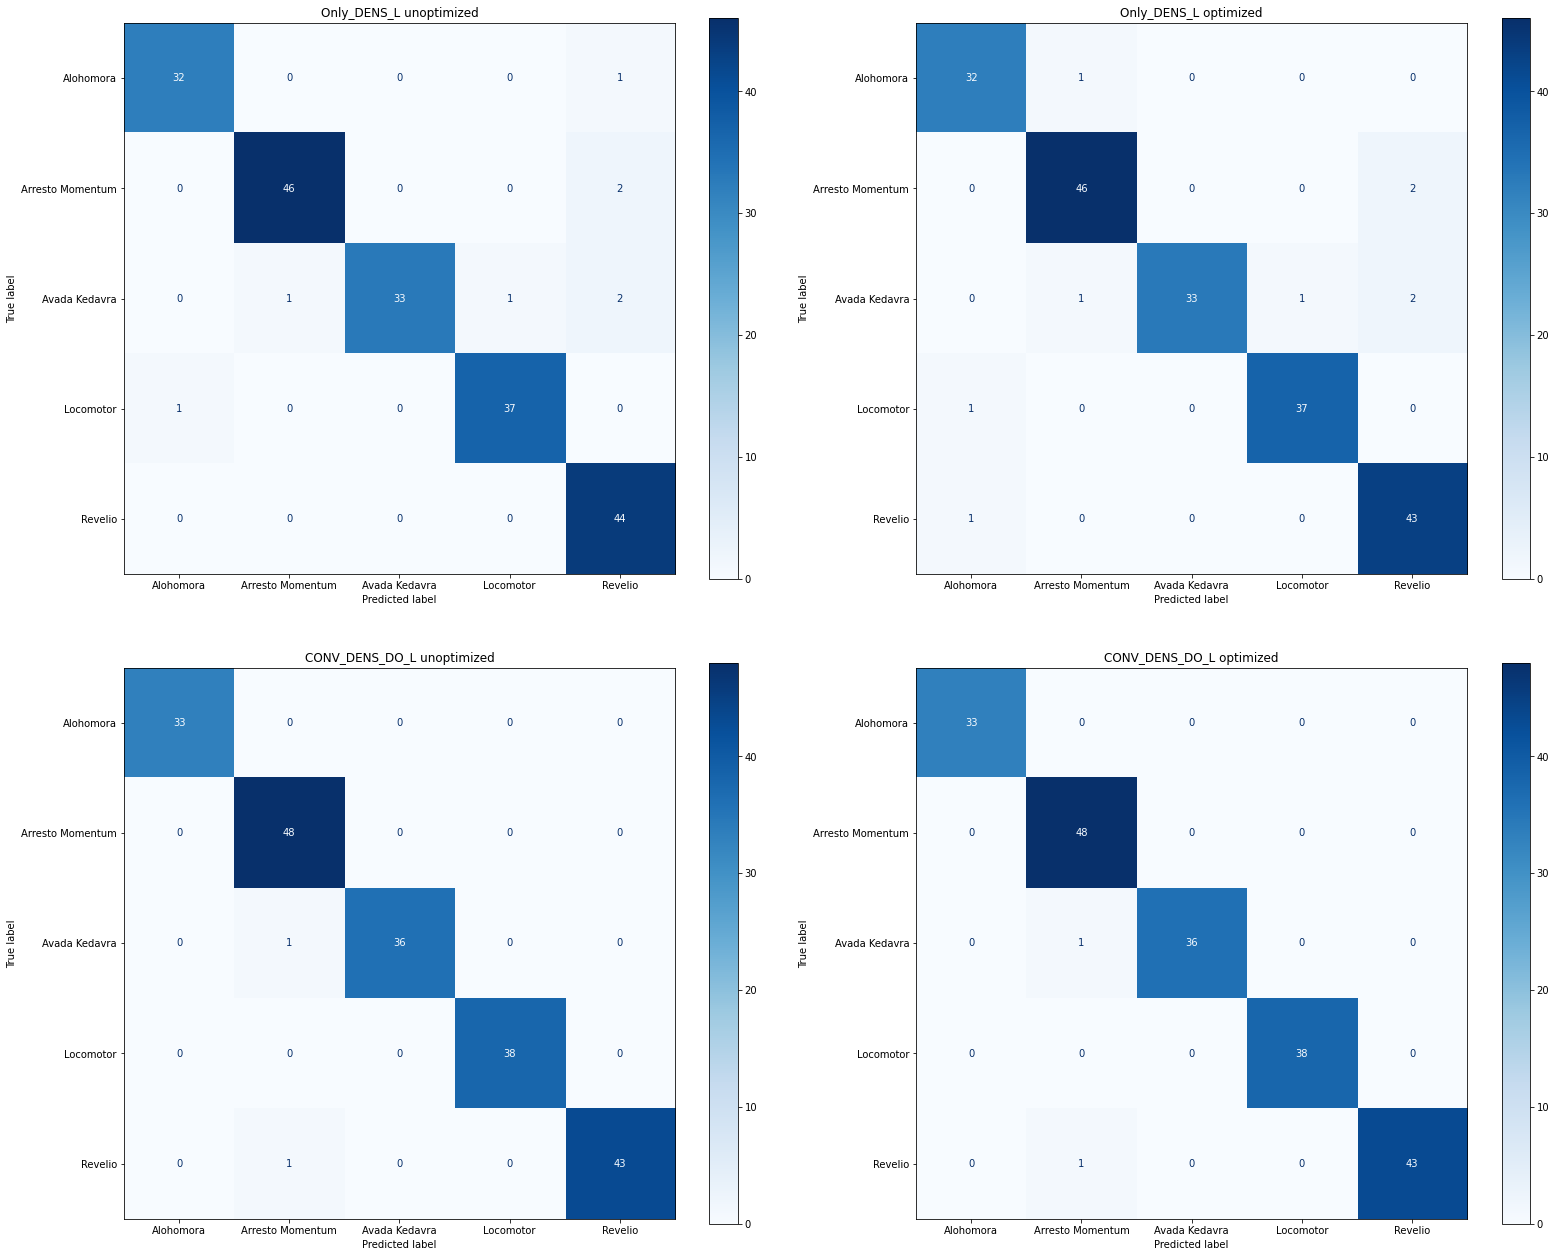

In [83]:
results = {}
figure, axis = plt.subplots(2, 2) # plot of the confusion matrix for selected models
figure.set_size_inches(22, 18)
axis_idx = 0
plt.subplots_adjust(left=0.085, bottom=0.04, right=1.02, top=0.97, hspace=0.15, wspace=0.15)

for model, model_name, data_set in zip(models, model_names, model_data_sets):
    X_train, X_test, y_train, y_test = data_sets[data_set]
    results[model_name] = {}
    results_model = results[model_name]
    results_model["Full model inference time"] = "-----"
    results_model["Optimized model inference time"] = "-----"

    # reset the seeds, so all models have the same starting point
    np.random.seed(SEED)
    random.seed(SEED)
    tf.random.set_seed(SEED)
    
    # get weights for the given seed
    model.build(X_train.shape)
    weights = model.get_weights()

    # get the best number of epochs based on validation data set
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=2,
                        callbacks=[tfc.EarlyStopping(monitor="val_accuracy", patience=3, mode="max", restore_best_weights=False)]).history
    model.set_weights(weights)
    epochs = len(history["loss"]) - 3
    results_model["Epochs"] = epochs
    
    # train on the whole train data set
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    train_start = time.time()
    model.fit(X_train, y_train, epochs=epochs, validation_split=0.0, batch_size=32, verbose=2)
    results_model["Training time GPU"] = f"{(time.time() - train_start):.2f} s"

    # predict and evaluate the prediction
    predictions = model.predict(X_test, verbose=2)
    predictions = np.argmax(predictions, axis=1)
    results_model["Full model accuracy"] = f"{((predictions == y_test).sum() / y_test.shape[0] * 100):.2f} \\%"

    # plot the full model confusion metrix
    if model_name in selected_models:
        confusion_matrix = tf.math.confusion_matrix(y_test, predictions).numpy()
        confusion_matrix = skm.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=LABELS)
        axis[axis_idx // 2, axis_idx % 2].set_title(f"{model_name} unoptimized")
        confusion_matrix.plot(cmap="Blues", ax=axis[axis_idx // 2, axis_idx % 2])
        axis_idx += 1

    # get the summary of the model
    model.summary(print_fn=lambda x, y=results_model: collect_model_summary(x, y))
    results_model["FLOPS"] = kf.get_flops(model, batch_size=1)

    # convert the model without optimiziation (evaluation is not necessary, the results after conversion are the same)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    results_file = open(f"models/{model_name}.tflite", "wb")
    results_file.write(tflite_model)
    results_file.close()
    results_model["Size"] = os.path.getsize(f"models/{model_name}.tflite")
    os.system(f'echo "const unsigned char model[] = {{" > models/{model_name}.h && cat models/{model_name}.tflite | xxd -i >> models/{model_name}.h && echo "}};" >> models/{model_name}.h && rm -f models/{model_name}.tflite')
    del tflite_model

    # convert the model with optimization 
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    converter.representative_dataset = lambda x=X_train: representative_dataset(x)
    tflite_model_opt = converter.convert()
    results_file = open(f"models/{model_name}.tflite", "wb")
    results_file.write(tflite_model_opt)
    results_file.close()
    results_model["Optimized size"] = os.path.getsize(f"models/{model_name}.tflite")
    os.system(f'echo "const unsigned char model[] = {{" > models/{model_name}_opt.h && cat models/{model_name}.tflite | xxd -i >> models/{model_name}_opt.h && echo "}};" >> models/{model_name}_opt.h && rm -f models/{model_name}.tflite')

    # predict using the optimized model and evaluate the prediction
    interpreter = tf.lite.Interpreter(model_content=tflite_model_opt)
    interpreter.allocate_tensors()
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_scale, input_zero_point = interpreter.get_output_details()[0]["quantization"]
    predictions = np.zeros((y_test.shape[0]))
    for i, sample in enumerate(X_test):
        interpreter.set_tensor(input_index, np.expand_dims(sample / input_scale + input_zero_point, 0).astype(np.int8))
        interpreter.invoke()
        predictions[i] = np.argmax(interpreter.get_tensor(output_index)[0]) # rescaling is not needed
    results_model["Optimized model accuracy"] = f"{((predictions == y_test).sum() / y_test.shape[0] * 100):.2f} \\%"
    
    # plot the confusuion matrix of the optimized model
    if model_name in selected_models:
        confusion_matrix = tf.math.confusion_matrix(y_test, predictions).numpy()
        confusion_matrix = skm.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=LABELS)
        axis[axis_idx // 2, axis_idx % 2].set_title(f"{model_name} optimized")
        confusion_matrix.plot(cmap="Blues", ax=axis[axis_idx // 2, axis_idx % 2])
        axis_idx += 1
    
    del tflite_model_opt

    # clear cell output after each model
    ipd.clear_output()

plt.savefig(f"figures/confusion_matrix.png", dpi=300)
plt.plot()

### Statistics and results

In [84]:
# export colected statistics to LaTex table and pandas data frame
data_frame = pd.DataFrame()
with open("results/statistics_large.tex" if LARGE_DATA_SET else "results/statistics.tex", "w") as results_file:
    print_rf = functools.partial(print, file=results_file)
    row_end = "\\\\"
    backslash_underscore = "\\_"
    print_rf("\\begin{table}[ht]", "\\begin{adjustwidth}{-0.85cm}{}" "\\tiny", "\\center", "\\begin{tabular}{ |c|c|c|c|c|c|c|c|c|c|c|c|c| }", sep="\n")        
    print_rf("\\hline")

    print_rf("& ", end="")
    for header in table_header[:-1]:
        print_rf(f"\\thead{{{header.replace('-', ' ').replace(' ', row_end)}}} & ", end="")
    print_rf(f"\\thead{{{table_header[-1].replace(' ', row_end)}}} {row_end}")
    print_rf("\\hline")

    for model_name in model_names:
        results_model = results[model_name]
        print_rf(f"\\thead{{{model_name.replace('_', backslash_underscore)}}} & ", end="")
        for header in table_header[:-1]:
            print_rf(f"{results_model[header]} & ", end="")
            data_frame.at[model_name, header] = results_model[header]
        print_rf(f"{results_model[table_header[-1]]} {row_end}")
        data_frame.at[model_name, table_header[-1]] = results_model[table_header[-1]]

    print_rf("\\hline")
    print_rf("\\end{tabular}")
    print_rf("\\caption{Summary of analyzed models during model selection and hyperparametr tuning.}")
    print_rf("\\label{table1}")
    print_rf("\\end{adjustwidth}", "\\end{table}", sep='\n')

data_frame.replace("\\\%", '%', regex=True)

,Total parameters,Trainable parameters,Non-trainable parameters,Size,Optimized size,Training time GPU,Epochs,FLOPS,Full model accuracy,Optimized model accuracy,Full model inference time,Optimized model inference time
baseline_linear,1195.0,1195.0,0.0,6072.0,2704.0,1.17 s,9.0,2410.0,86.00 %,88.00 %,-----,-----
Only_DENS_S,13355.0,13355.0,0.0,55840.0,16512.0,1.28 s,6.0,26655.0,93.00 %,92.00 %,-----,-----
Only_DENS_M,24405.0,24405.0,0.0,99484.0,26936.0,2.49 s,6.0,48730.0,93.50 %,92.50 %,-----,-----
Only_DENS_L,29205.0,29205.0,0.0,119240.0,32584.0,1.78 s,15.0,58280.0,96.00 %,95.50 %,-----,-----
CONV_DENS_S,10181.0,10181.0,0.0,45724.0,17632.0,9.89 s,15.0,537886.0,97.50 %,97.50 %,-----,-----
CONV_DENS_L,40069.0,40069.0,0.0,165276.0,49128.0,4.48 s,6.0,2013726.0,96.00 %,96.00 %,-----,-----
Only_CONV_S,23877.0,23877.0,0.0,100664.0,32808.0,4.72 s,10.0,584670.0,96.50 %,96.00 %,-----,-----
Only_CONV_L,93829.0,93829.0,0.0,380472.0,105784.0,4.59 s,8.0,1906590.0,96.50 %,96.00 %,-----,-----
Only_DENS_DO_S,13355.0,13355.0,0.0,55840.0,16512.0,2.42 s,14.0,26655.0,94.50 %,93.00 %,-----,-----
Only_DENS_DO_M,24405.0,24405.0,0.0,99484.0,26936.0,0.94 s,10.0,48730.0,94.50 %,93.50 %,-----,-----
